# Capstone Hotel reservation prediction

![Logo](img/hotel-logo.png)

## Modelling

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

#modelling
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, RandomizedSearchCV, train_test_split
from sklearn.utils import resample

#visualisations
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
'''
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
'''

'\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.feature_selection import SelectFromModel\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.linear_model import LinearRegression, LassoCV\nfrom sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures\nfrom sklearn.pipeline import Pipeline\n'

In [3]:
#import eli5 # https://pypi.org/project/eli5/

#### Loading cleaned dataset

In [4]:
df = pd.read_csv("data/dataset_w_feature.csv", index_col=0, encoding="iso-8859-15")

In [5]:
df["buchungsdatum"]      = pd.to_datetime(df["buchungsdatum"])
df["anreisedatum"]       = pd.to_datetime(df["anreisedatum"])
df["abreisedatum"]       = pd.to_datetime(df["abreisedatum"])

In [6]:
df.head()

,buchungsdatum,anreisedatum,abreisedatum,naechte_insgesamt,gebuchte_naechte,personen_anzahl,gesamtpreis,saison,buchung_telefon,buchung_online,buchung_reisebuero,zimmerarten,reise_adventure,reise_relax,reise_standard,reise_genuss,kind,entfernung,zahler,kunden_id,buchungsnr,buchungsnr_reisebuero,menue_code,zusatzleistung,destination,anrede,plz,ort,kundenclub,jahrgangsalter_klassiert,bundesland,einwohner_adjusted_plz,bev_m_plz,bev_w_plz,bev_insgesamt_ort,bev_weiblich_ort,bev_maennlich_ort,qkm_plz,flaeche_ort,einwohnerdichte_prokm2_plz,haushalte_regiog_2017_plz,kaufkraft_einwohner_in_eur_regio,kk_einwohner_index_regiog_2017,kk_hh_index_regiog_2017,gemeindetyp_regiostar_2016,wirtschaftskraftmr1,wirtschaftskraftmr2,buchungsjahr,buchungsquartal,buchungsmonat,buchungswoche,buchungstag,buchung_wochentag,anreisejahr,anreisequartal,anreisemonat,anreisewoche,anreisetag,anreise_wochentag,abreisejahr,abreisequartal,abreisemonat,abreisewoche,abreisetag,abreise_wochentag,buchungsmonat-jahr,buchungsquartal-jahr,anreisemonat-jahr,anreisequartal-jahr,abreisemonat-jahr,abreisequartal-jahr,buchungskanal,werbe_ban,anz_werbe_ban,aufenthalt,naechte_ausserhalb,anz_buch,buchungsvorlauf,preis_per,preis_nacht,preis_nacht_per,buch_zeilen,erstbuchung,folgebuchung,repeater
0,2010-01-29,2010-04-02,2010-04-10,8,8,2,2982,2010,0,0,1,classic,0,0,0,1,0,535.48,1,1,1151,456,5,5,linz,Herr,29664,Walsrode,0,55-64,Niedersachsen,25173,12540,12633,25173,11577,11491,344.326464,344.326464,73.108,11453,20641.89,92.819,98.104,Landregion - Zentrale Stadt,-0.333392,-0.388738,2010,1,1,4,4,Freitag,2010,2,4,13,4,Freitag,2010,2,4,14,5,Samstag,2011,2011,2014,2012,2014,2012,reisebuero,keine,0,8,0,1,63,1491.00,372.75,186.38,2,1,0,0
1,2010-01-14,2010-04-05,2010-04-10,5,5,2,1437,2010,0,0,1,classic,0,0,1,0,0,544.72,0,2,40,6413,5,5,linz,Frau,50226,Frechen,0,55-64,Nordrhein-Westfalen,52473,25645,26828,52473,26828,25645,45.118960,45.118960,1162.992,26227,25268.58,113.623,111.379,Landregion - Zentrale Stadt,0.853802,-0.345112,2010,1,1,2,3,Donnerstag,2010,2,4,14,0,Montag,2010,2,4,14,5,Samstag,2011,2011,2014,2012,2014,2012,reisebuero,generell,5,5,0,1,81,718.50,287.40,143.70,2,1,0,0
2,2010-03-01,2010-04-05,2010-04-10,5,5,2,1737,2010,0,0,1,classic,0,0,1,0,0,606.63,0,3,2134,4322,5,5,linz,Herr,23970,Wismar,0,75-84,Mecklenburg-Vorpommern,1423,692,731,46442,21844,20706,50.563027,83.131346,17.117,6355,18697.65,84.076,73.665,"Stadtregion - Kleinstädtischer, dörflicher Raum",-1.012536,-1.012536,2010,1,3,9,0,Montag,2010,2,4,14,0,Montag,2010,2,4,14,5,Samstag,2013,2011,2014,2012,2014,2012,reisebuero,keine,0,5,0,1,35,868.50,347.40,173.70,1,1,0,0
3,2010-01-25,2010-03-21,2010-03-25,4,4,2,1047,2010,0,0,1,classic,0,1,0,0,0,421.59,1,4,776,6414,69,9,linz,Frau,15732,Eichwalde,0,65-74,Brandenburg,14690,7302,7388,14690,4135,4087,11.965427,11.965427,1227.704,7159,23442.06,105.410,104.087,Landregion - Städtischer Raum,0.417226,0.417226,2010,1,1,4,0,Montag,2010,1,3,11,6,Sonntag,2010,1,3,12,3,Donnerstag,2011,2011,2013,2011,2013,2011,reisebuero,keine,0,4,0,1,55,523.50,261.75,130.88,1,1,0,0
4,2010-01-26,2010-03-07,2010-03-09,2,2,20,5279,2010,0,0,1,classic,1,0,0,0,0,37.88,0,5,813,2938,113,2,duesseldorf,Frau,53881,Euskirchen,1,45-54,Nordrhein-Westfalen,28531,13975,14556,57975,29578,28397,127.679129,139.430913,204.625,11683,23328.82,104.901,120.110,"Stadtregion - Kleinstädtischer, dörflicher Raum",0.212335,-0.579173,2010,1,1,4,1,Dienstag,2010,1,3,9,6,Sonntag,2010,1,3,10,1,Dienstag,2011,2011,2013,2011,2013,2011,reisebuero,keine,0,2,0,1,40,263.95,2639.50,131.98,7,1,0,1


## Preparation

#### Dropping redundant variables

In [7]:
df.drop("buchungskanal", axis=1, inplace=True)
df.drop("werbe_ban", axis=1, inplace=True)

#### Grouping variables

In [8]:
categorial = list(df.columns[df.dtypes==object])
datetime64 = ['buchungsdatum', 'anreisedatum', 'abreisedatum']
numeric    = list(df.select_dtypes(include=['int64', 'float64']).columns)

for entry in ['erstbuchung', 'repeater', 'kunden_id', 'folgebuchung', 'menue_code', 'zusatzleistung', 'plz', 'kundenclub', 'anz_buch']: 
    numeric.remove(entry)
    
for entry in ['menue_code', 'zusatzleistung']: 
    categorial.append(entry)    

categorial.remove('ort')

# 7 = 'erstbuchung', 'repeater', 'kunden_id', 'folgebuchung', 'plz', 'kundenclub', 'ort'
df.shape[1] == len(categorial) + len(datetime64) + len(numeric) + 7

False

#### renaming destinations

In [9]:
aenderung = { "saint etienne": "saint-etienne",
              "viana do castelo": "viana-do-castelo",
            }

df.destination.replace(aenderung, inplace=True)

aenderung2 = {
"Landregion - Kleinstädtischer, dörflicher Raum": "Kleinstädt_(Land)",
"Landregion - Städtischer Raum": "Stadt_(Land)",
"Landregion - Zentrale Stadt": "zen_Stadt_(Land)",
"Stadtregion - Kleinstädtischer, dörflicher Raum": "Kleinstädt_(Stadt)",
"Stadtregion - Metropole": "Metropole",
"Stadtregion - Mittelstadt, städtischer Raum": "Mittelstadt",
"Stadtregion -Regiopole und Großstadt": "Regiopole"
    }

df.gemeindetyp_regiostar_2016.replace(aenderung2, inplace=True)

### Dummy Variable

In [10]:
df_dum = pd.get_dummies(df[categorial])
# bei vielen Ausprägungen bins, erst einmal ohne
df_dum.shape

(160259, 67)

Transform menue_code and zusatzleistung to string to convert to dummies

In [11]:
df.menue_code     = df.menue_code.astype("str")
df.zusatzleistung = df.zusatzleistung.astype("str")

## Logistic Regression
Basic (only numeric features)

In [12]:
X = df[numeric]
y = df.folgebuchung

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1337)

In [13]:
lr1 = LogisticRegression(solver='liblinear', max_iter=10_000)

scoring = ['precision', 'recall', 'f1', 'roc_auc']
scores1 = cross_validate(lr1, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
# cv can also return train score but we set it to false

y_pred1 = cross_val_predict(lr1, X_train, y_train, cv=5)

### extended Logistic Regression
(categorial variables as dummies)

In [14]:
X = pd.concat([df[numeric], df_dum], axis=1)
y = df.folgebuchung

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1337)

In [15]:
lr2 = LogisticRegression(solver='liblinear', max_iter=10_000)

scores2 = cross_validate(lr2, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

y_pred2 = cross_val_predict(lr2, X_train, y_train, cv=5)

### Dealing with imbalace 
in target feature folgebuchung by resampling

In [16]:
df.folgebuchung.value_counts()

0    129462
1     30797
Name: folgebuchung, dtype: int64

#### Upsampling

In [17]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
erstbuchung  = X[X.folgebuchung==0]
folgebuchung = X[X.folgebuchung==1]

# upsample minority
folgebuchung_upsampled = resample(folgebuchung, replace=True, 
                          n_samples=len(erstbuchung), # match number in majority class
                          random_state=1337) 

# combine majority and upsampled minority
upsampled = pd.concat([erstbuchung, folgebuchung_upsampled])

upsampled.folgebuchung.value_counts()

1    116558
0    116558
Name: folgebuchung, dtype: int64

#### Downsampling

In [18]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
erstbuchung  = X[X.folgebuchung==0]
folgebuchung = X[X.folgebuchung==1]

# downsample majority
erstbuchung_downsampled = resample(erstbuchung, replace=False, 
                          n_samples=len(folgebuchung), # match minority n
                          random_state=1337) 

# combine majority and upsampled minority
downsampled = pd.concat([folgebuchung, erstbuchung_downsampled])

downsampled.folgebuchung.value_counts()

1    27675
0    27675
Name: folgebuchung, dtype: int64

### balanced Logistic Regression
with downsampled data and additional dummy variables

In [19]:
y_train = upsampled.folgebuchung
X_train = upsampled.drop('folgebuchung', axis=1)

lr3 = LogisticRegression(solver='liblinear', max_iter=10_000)

scores3 = cross_validate(lr3, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

### balanced Logistic Regression
downsampled

In [20]:
y_train = downsampled.folgebuchung
X_train = downsampled.drop('folgebuchung', axis=1)

lr4 = LogisticRegression(solver='liblinear', max_iter=10_000)

scores4 = cross_validate(lr4, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

# Decision Trees
## Random forest

In [21]:
X = pd.concat([df[numeric], df_dum], axis=1)
y = df.folgebuchung

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1337)

lr5 = RandomForestClassifier(max_depth=5, n_estimators=7, random_state=1337).fit(X_train,y_train)
y_pred5 = lr5.predict(X_test)

In [22]:
print(confusion_matrix(y_test,y_pred5))
print(classification_report(y_test,y_pred5))
print(accuracy_score(y_test,y_pred5))

[[12895     9]
 [ 3030    92]]
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     12904
           1       0.91      0.03      0.06      3122

    accuracy                           0.81     16026
   macro avg       0.86      0.51      0.48     16026
weighted avg       0.83      0.81      0.73     16026

0.8103706476974916


In [23]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(2, 6, 11, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(5, 10, 15, dtype = int))}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 20, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train,y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   42.9s finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 2, 2, 3, 3, 4, 4, 4, 5,
                                                      5, 6, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [5, 5, 5, 6, 6, 6, 7, 7,
                                                         7, 8, 8, 8, 9, 9,
                                                         10]},
                   random_state=101, verbose=5)

In [24]:
model.best_params_

{'n_estimators': 7,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'max_depth': None,
 'criterion': 'gini'}

In [25]:
model.best_score_

0.8420680442444406

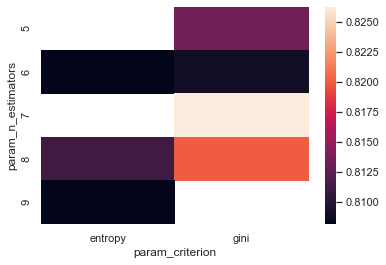

In [26]:
table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

In [27]:
predictionforest = model.best_estimator_.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc3 = accuracy_score(y_test,predictionforest)

[[12498   406]
 [ 2004  1118]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     12904
           1       0.73      0.36      0.48      3122

    accuracy                           0.85     16026
   macro avg       0.80      0.66      0.70     16026
weighted avg       0.84      0.85      0.83     16026



In [28]:
stop

NameError: name 'stop' is not defined

In [ ]:
X = pd.concat([df[numeric], df_dum], axis=1)
y = df.folgebuchung

#X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1337)

lr5 = RandomForestClassifier(max_depth=2, random_state=0)

scores5 = cross_validate(lr5, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

a. max_leaves (here: 6)
b. max_depth (here: 3)
c. min_sample_split (here: 400)
d. max_features (here: 6) - not always helpful

#### Confusion Matrix & Classification Report
<img src="img/conf_matrix.png" alt="Drawing" style="width: 400px;"/>

Feature Importance

In [ ]:
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

Receiver Operating Statistic (ROC) and the Area Under the Curve (AUC)

In [ ]:
stop

fpr_RF, tpr_RF, thresholds_RF = roc_curve(df.actual_label.values, df.model_RF.values)
fpr_LR, tpr_LR, thresholds_LR = roc_curve(df.actual_label.values, df.model_LR.values)

plt.plot(fpr_RF, tpr_RF,'r-',label = 'RF')
plt.plot(fpr_LR,tpr_LR,'b-', label= 'LR')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
#https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter

#sklearn.pipeline.Pipeline 

In [ ]:
#df_dum.head(2)

In [ ]:
#categorial

In [ ]:
conf_matrix1 = confusion_matrix(y_test, y_pred1)
class_rep1 = classification_report(y_test, y_pred1)
acc1 = accuracy_score(y_test, y_pred)*100
pre1 = precision_score(y_test, y_pred)*100
rec1 = recall_score(y_test, y_pred)*100
f1-1 = f1_score(y_test, y_pred)*100
score1